In [1]:
%matplotlib inline

# Manifold learning on images features: Locally Linear Embedding, Isomap...

In [138]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

print(__doc__)
from time import time

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import matplotlib.image as mpimg
import cv2
IMG_SIZE = 64
from matplotlib._png import read_png
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

# digits = datasets.load_digits(n_class=6)
# X = digits.data
# y = digits.target
# n_samples, n_features = X.shape
n_neighbors = 30

Automatically created module for IPython interactive environment


In [36]:
import pickle
stat_embeddings = pickle.load(open( "data/stat_embeddings_numpy.pickle", "rb"))
stat_embeddings = np.array(stat_embeddings).reshape((211, 512))

In [49]:
N_IMAGES = 211
def preprocess_attributes():
    attr_lines = [line.rstrip() for line in open('data/list_attr_stat.txt', 'r')]
    assert len(attr_lines) == N_IMAGES + 2

    attr_keys = attr_lines[1].split()
    attributes = {k: np.zeros(N_IMAGES, dtype=np.int) for k in attr_keys}

    for i, line in enumerate(attr_lines[2:]):
        image_id = i + 1
        split = line.split()
        assert len(split) == 41
        for j, value in enumerate(split[1:]):
            if value == '1':
                attributes[attr_keys[j]][i] = 1
            else:
                attributes[attr_keys[j]][i] = 0
    return attributes

In [50]:
attributes = preprocess_attributes()
sexual_indicator = attributes['Male']

In [118]:
data_folder = "data\\image"
data_names = [os.path.join(data_folder, name) for name in sorted(os.listdir(data_folder))]

In [114]:
X = stat_embeddings
y = sexual_indicator
n_samples, n_features = X.shape

In [175]:
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    y_label = ["F", "M"]

    plt.figure(figsize=(20,20))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_label[y[i]]),
                 color=plt.cm.Set1((y[i]) / 1.),
                 fontdict={'weight': 'bold', 'family': 'serif', 'size': 30})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            face_img = mpimg.imread(data_names[i])
            face_img = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(face_img), X[i])
            
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Text(0.5, 1.0, 'A selection from the Purdue-STAT-faces dataset')

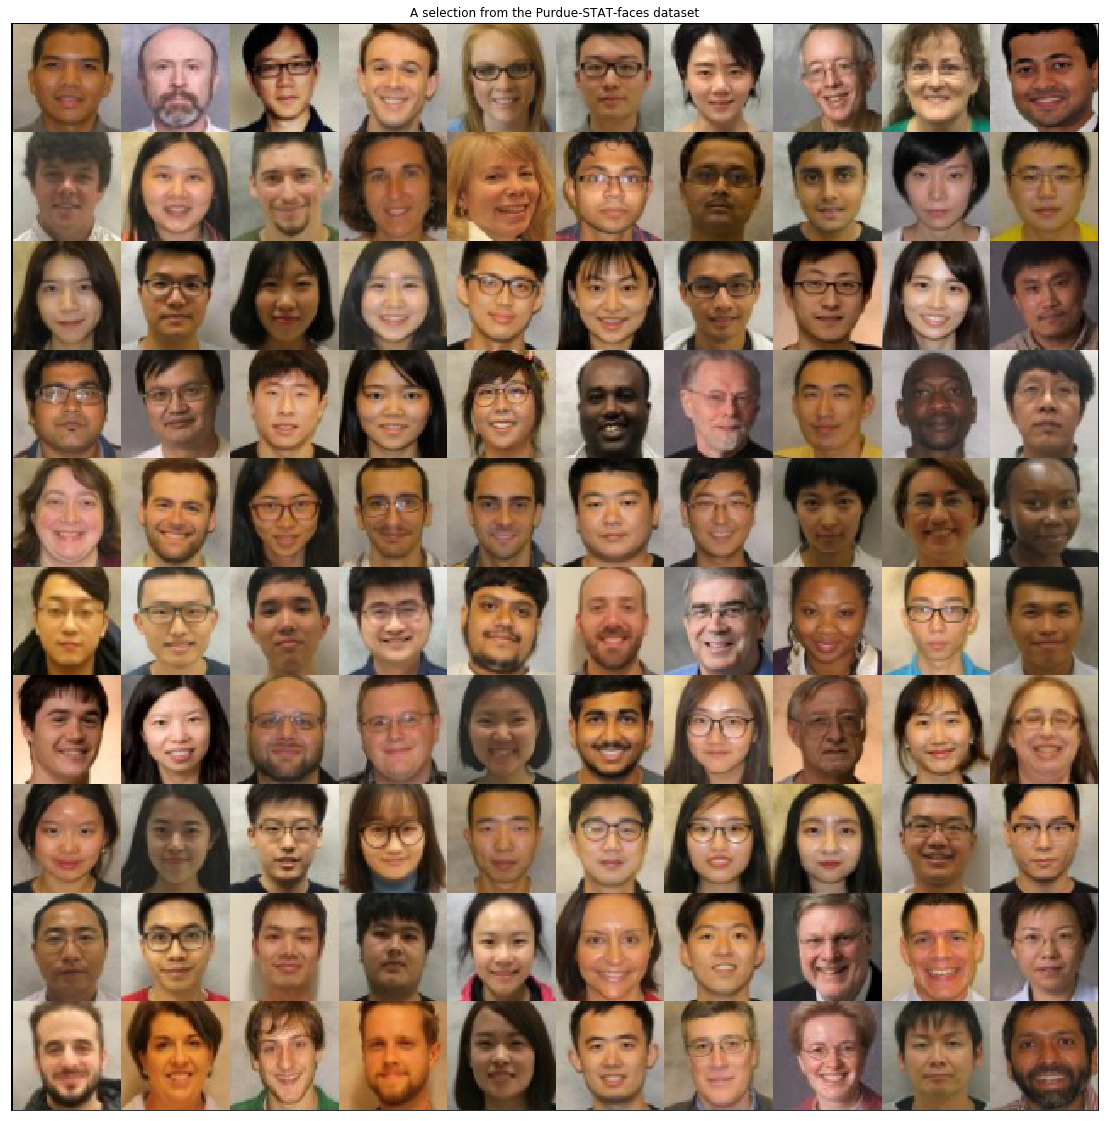

In [182]:
#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 10
img = np.zeros((IMG_SIZE * n_img_per_row + 1, IMG_SIZE * n_img_per_row + 1, 3))
for i in range(n_img_per_row):
    ix = IMG_SIZE * i + 1
    for j in range(n_img_per_row):
        iy = IMG_SIZE * j + 1
        face_img = mpimg.imread(data_names[i * n_img_per_row + j])
        face_img = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        img[ix:ix + 64, iy:iy + 64, 0:3] = face_img / 256

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the Purdue-STAT-faces dataset')

Computing random projection


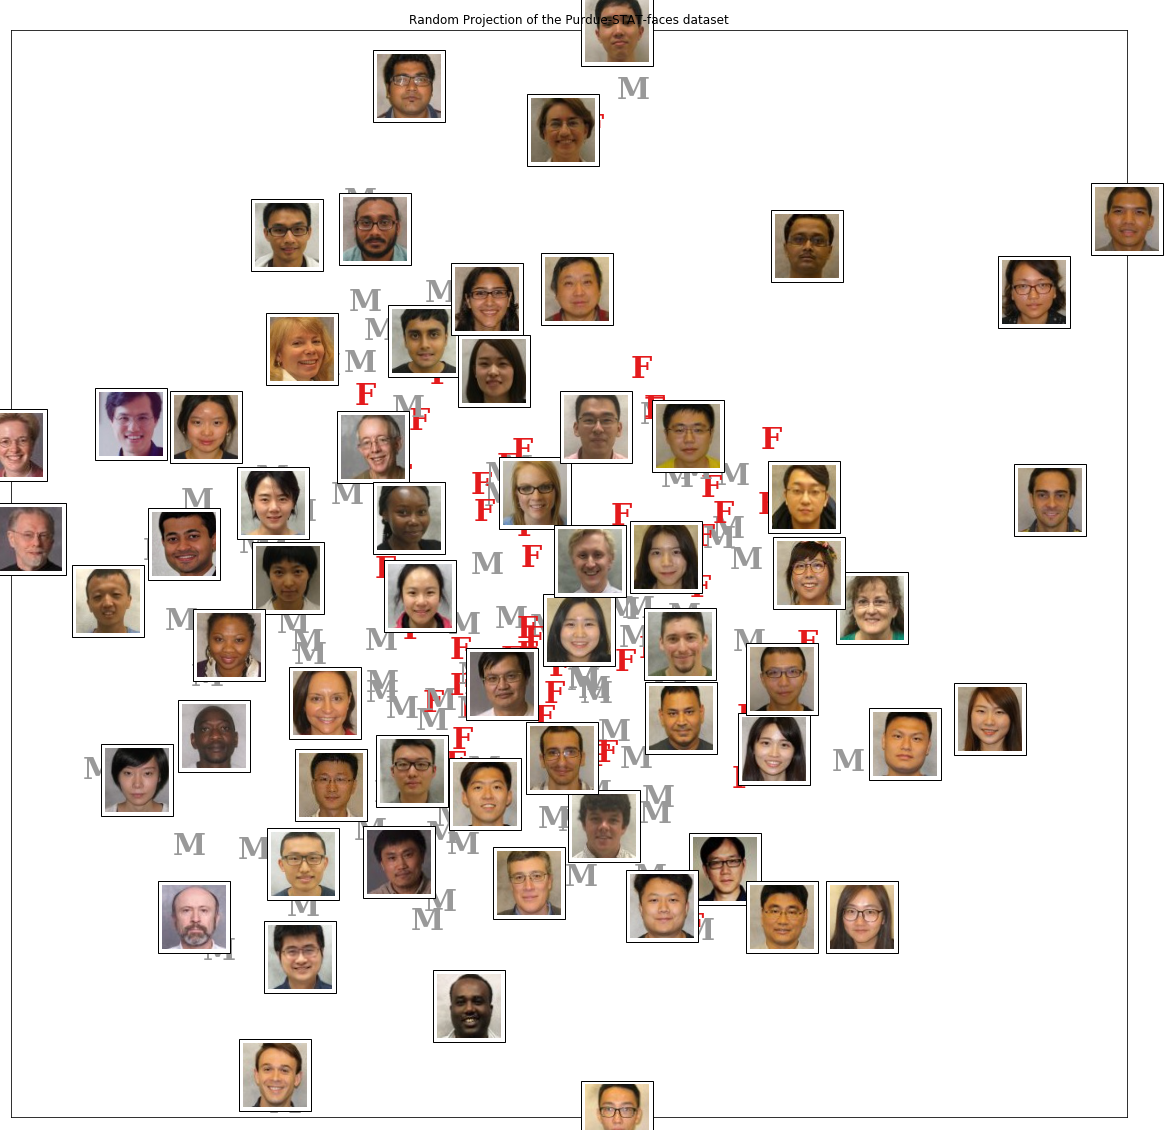

In [183]:
#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the Purdue-STAT-faces dataset")

Computing PCA projection


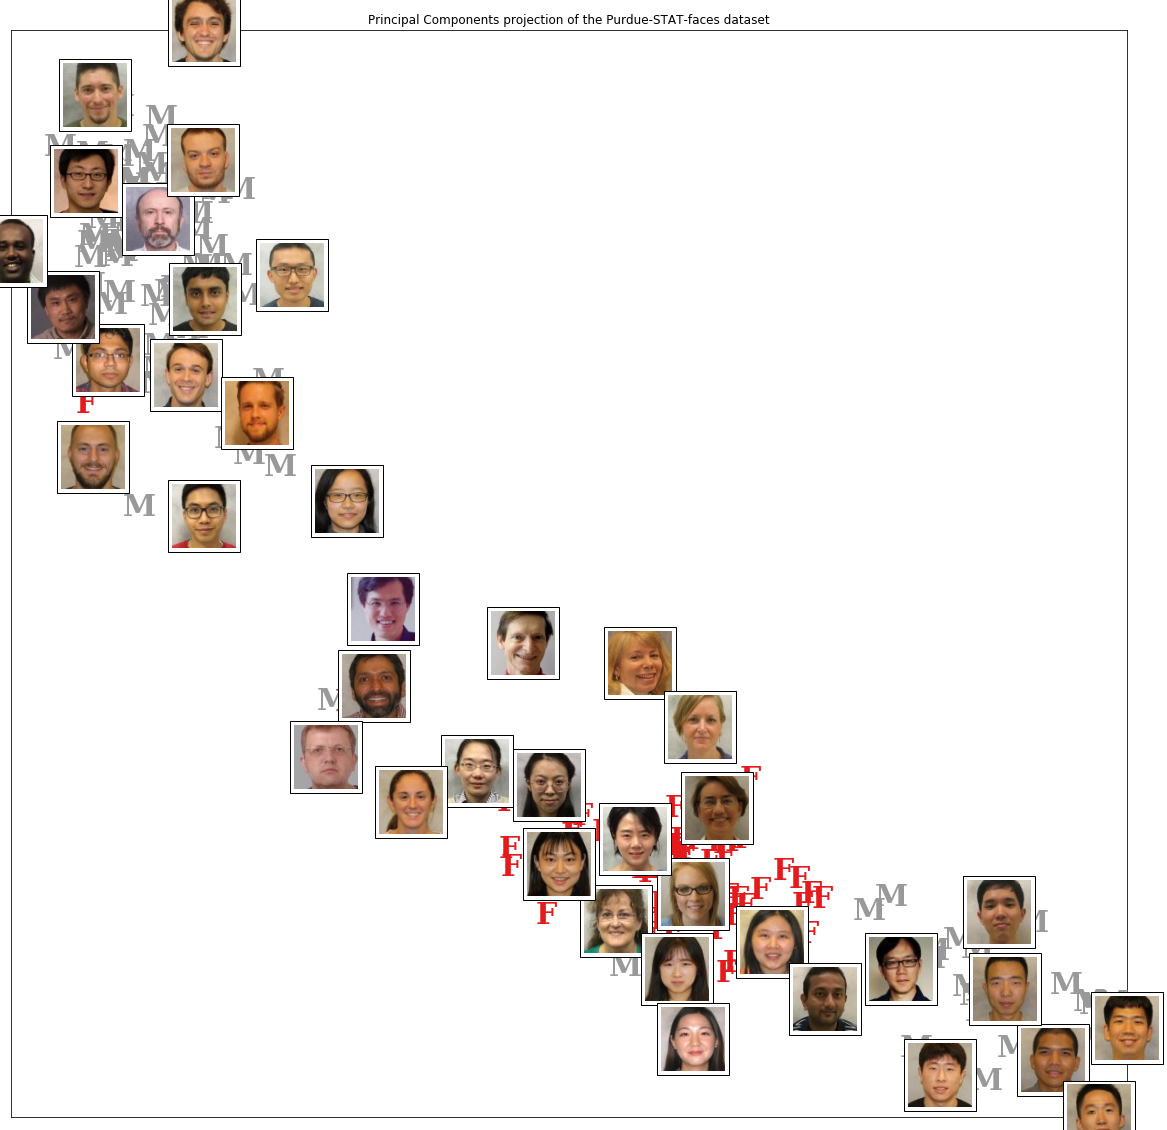

In [184]:
#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the Purdue-STAT-faces dataset")

In [185]:
#----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the Purdue-STAT-faces dataset")

Computing Isomap embedding
Done.


Computing LLE embedding
Done. Reconstruction error: 0.0414095


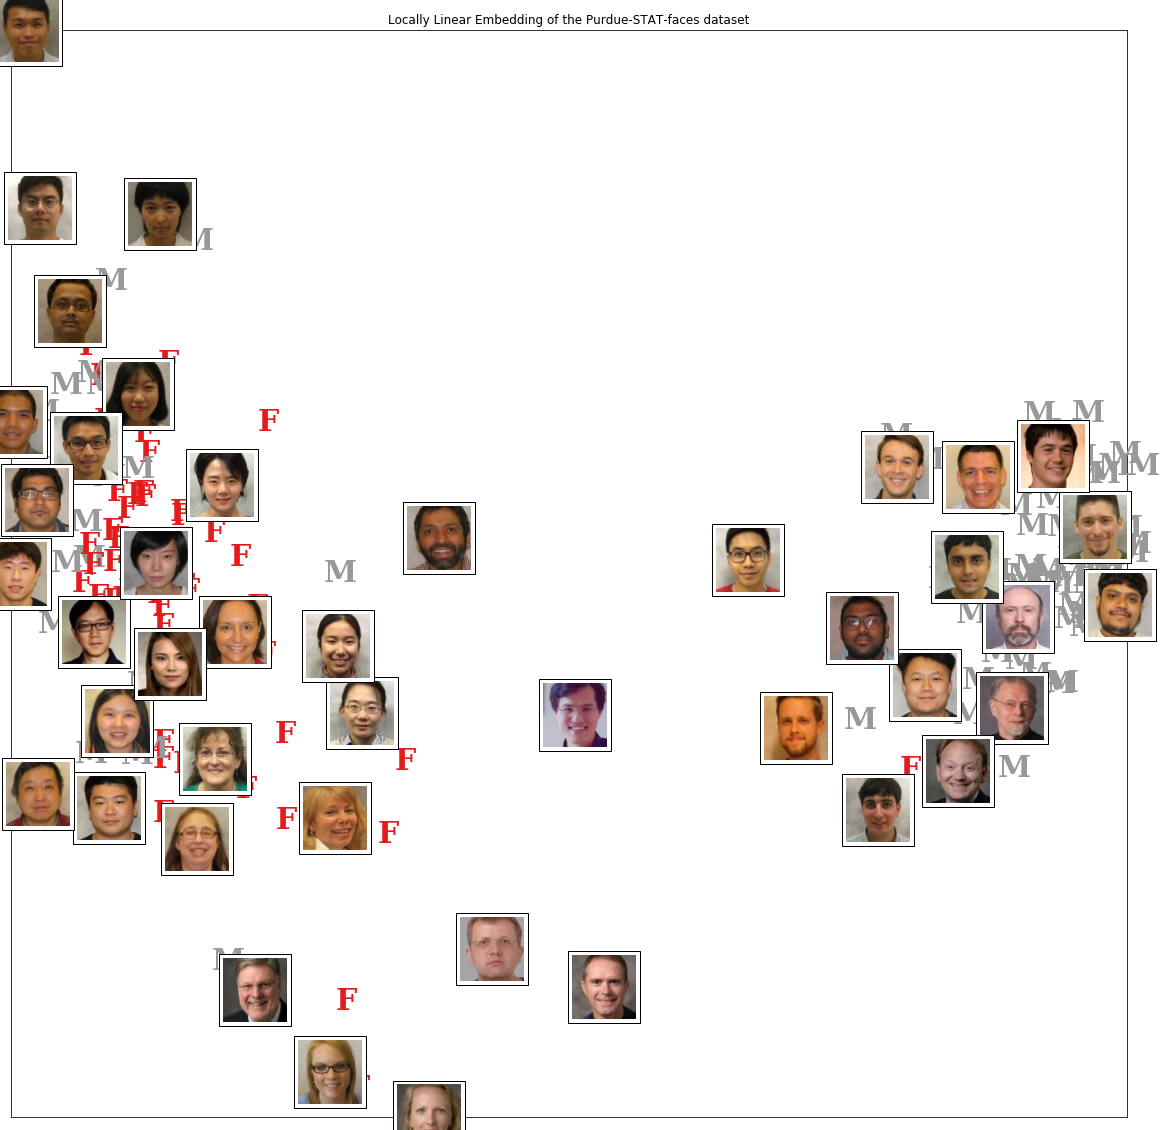

In [186]:
#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the Purdue-STAT-faces dataset")

Computing modified LLE embedding
Done. Reconstruction error: 7.19807


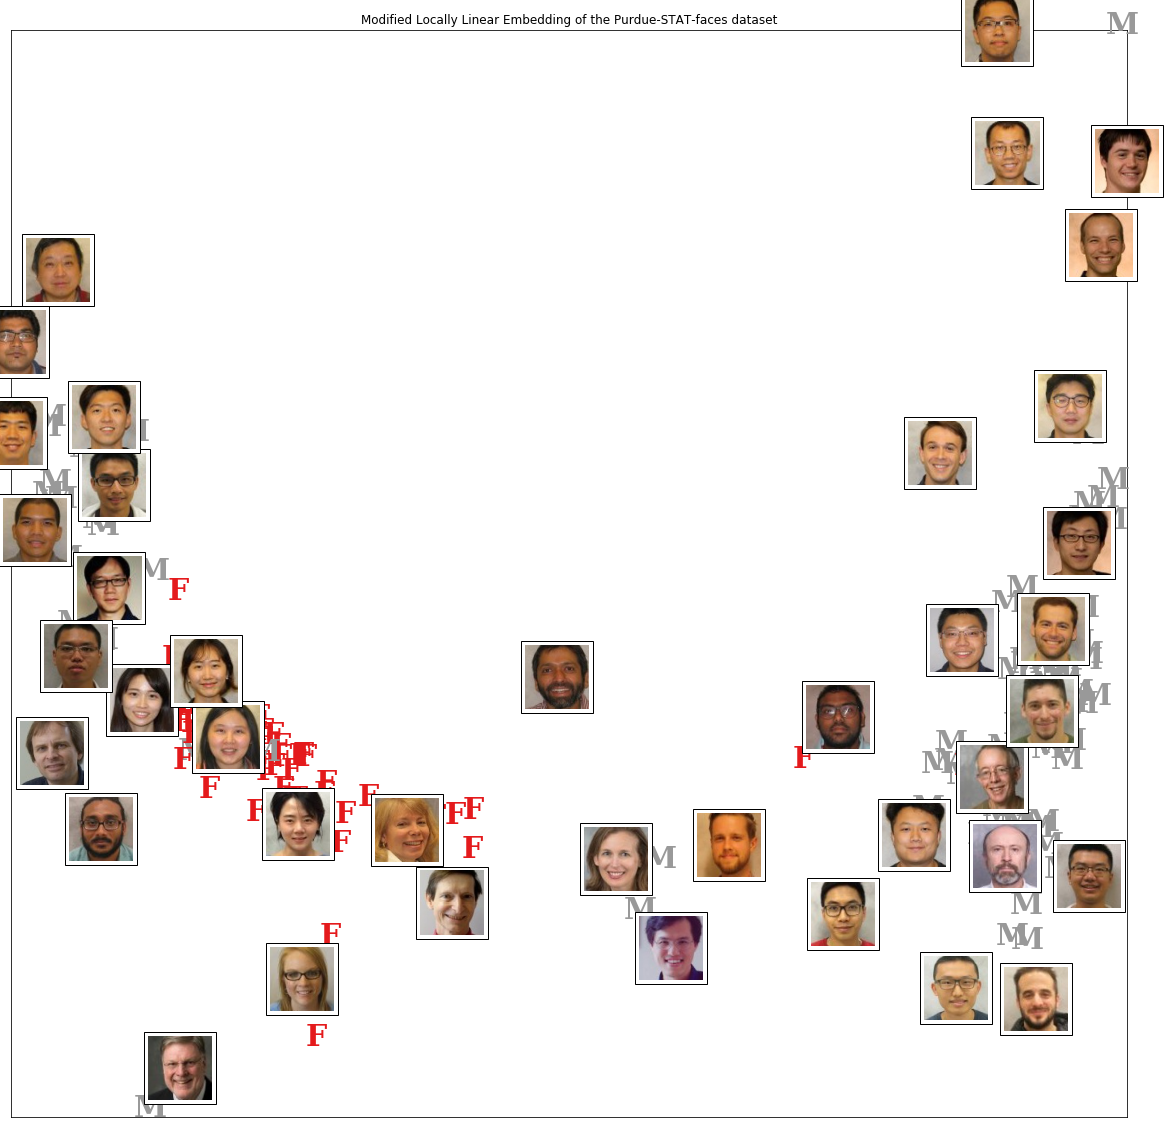

In [187]:
#----------------------------------------------------------------------
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the Purdue-STAT-faces dataset")

Computing MDS embedding
Done. Stress: 738188.600813


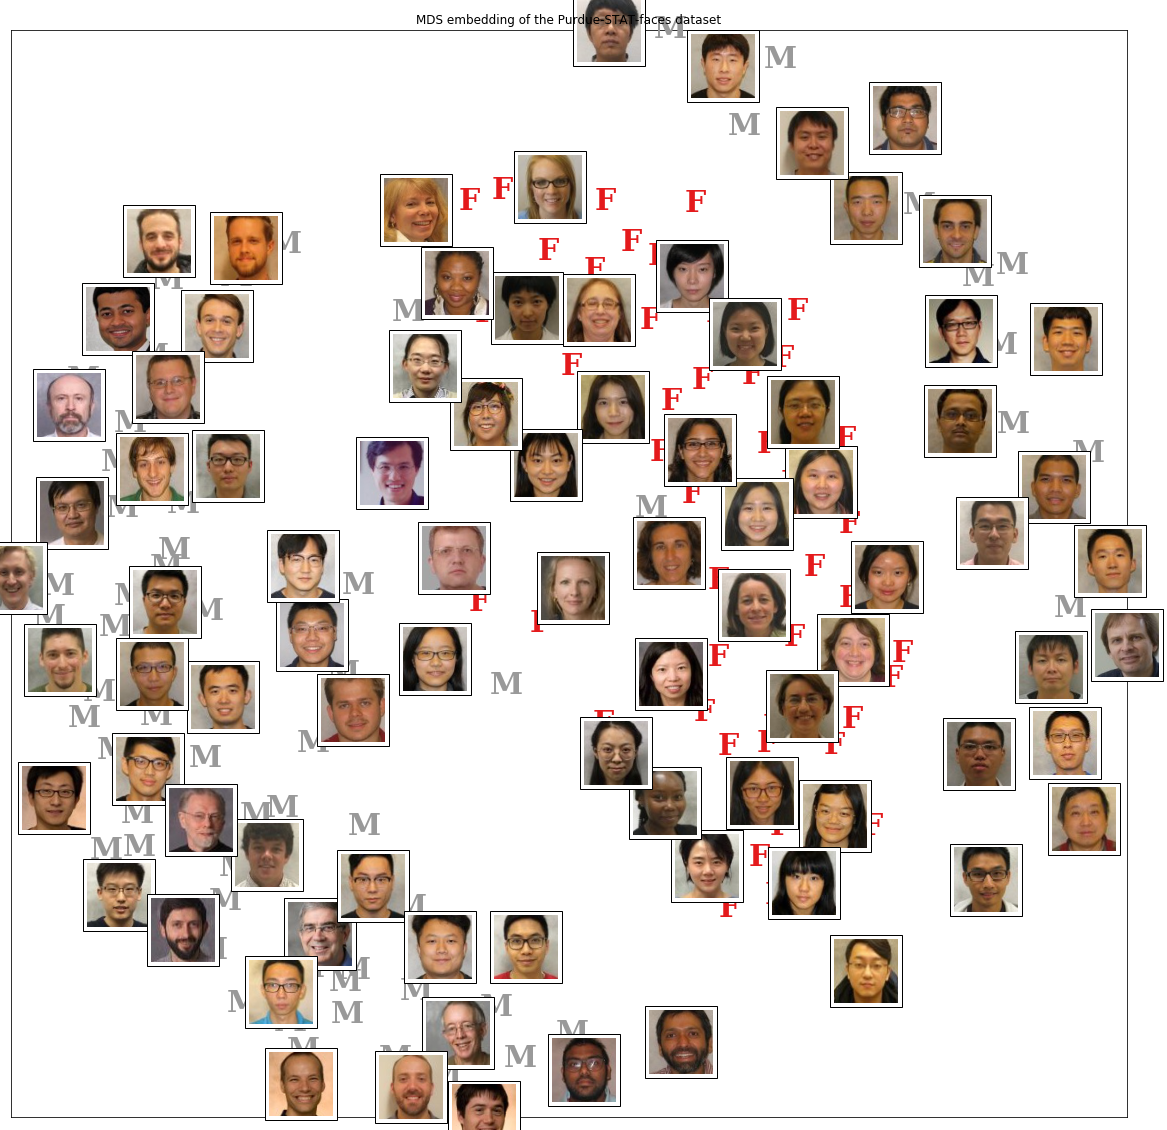

In [193]:
#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds, "MDS embedding of the Purdue-STAT-faces dataset")
plt.savefig('embedding_MDS.png')

Computing Totally Random Trees embedding


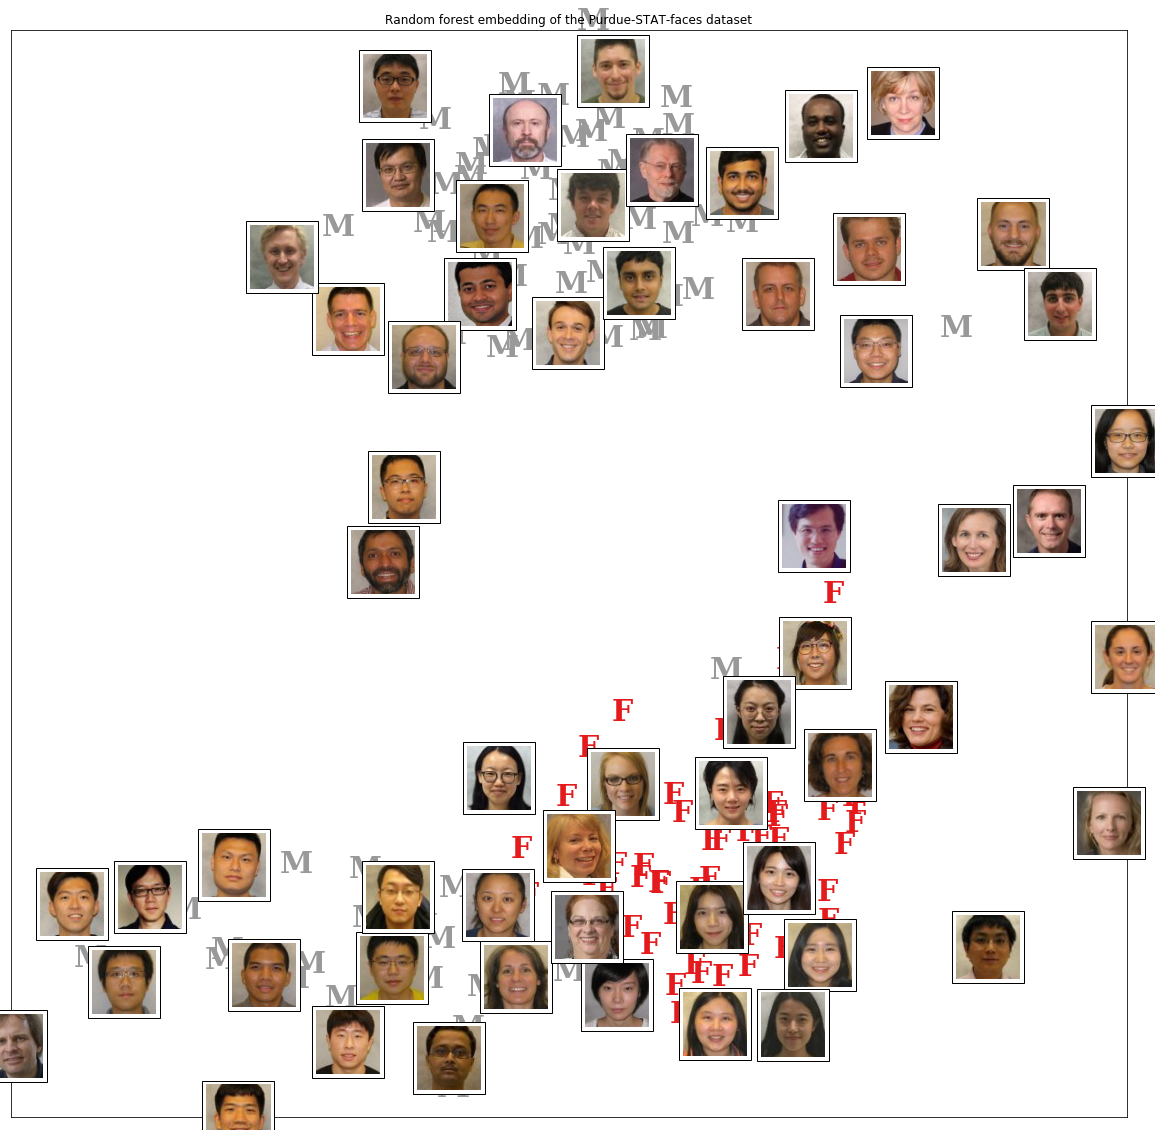

In [189]:
#----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced,
               "Random forest embedding of the Purdue-STAT-faces dataset")

In [190]:
#----------------------------------------------------------------------
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the Purdue-STAT-faces dataset")

Computing Spectral embedding


Computing t-SNE embedding


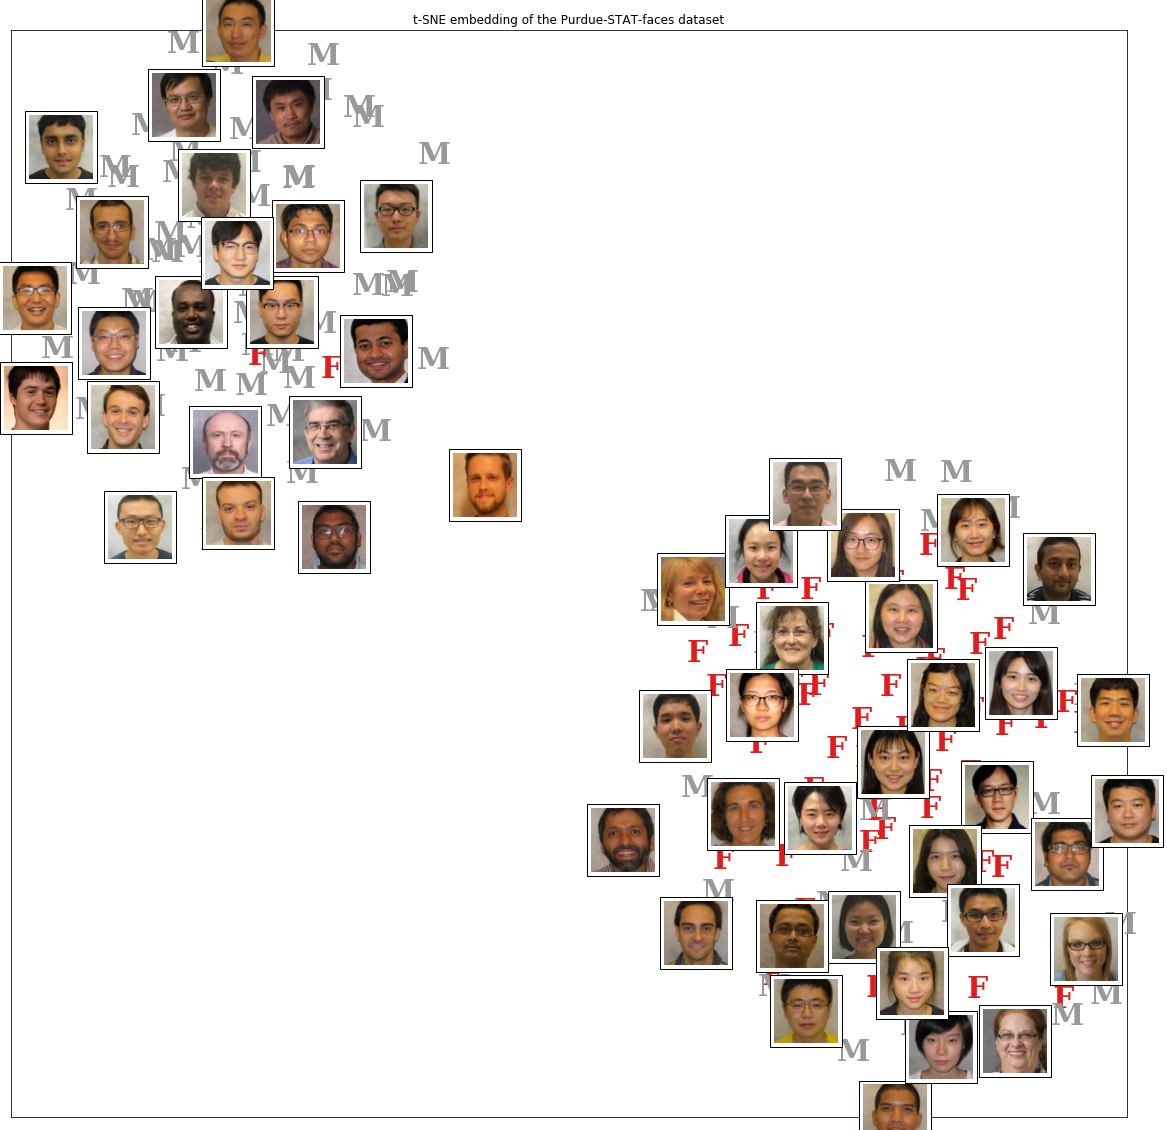

In [192]:
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
# t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, "t-SNE embedding of the Purdue-STAT-faces dataset")

plt.savefig('embedding_t-SNE.png')